In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
import lightning as L
from lightning import Trainer, LightningModule
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor

from helper import StockDataset, normalize, sliding_window, train_test_split, recover_normalize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
torch.set_float32_matmul_precision('medium')
L.seed_everything(42)

Global seed set to 42


42

In [3]:
df = pd.read_parquet("./data/close.parquet")
df

,date,close,high,low
0,2000-01-04,6110,6110,5660
1,2000-01-05,5580,6060,5520
2,2000-01-06,5620,5780,5580
3,2000-01-07,5540,5670,5360
4,2000-01-10,5770,5770,5580
...,...,...,...,...
5833,2023-08-17,66700,66800,66000
5834,2023-08-18,66300,66700,65800
5835,2023-08-21,66600,67100,66300
5836,2023-08-22,66600,67700,66300


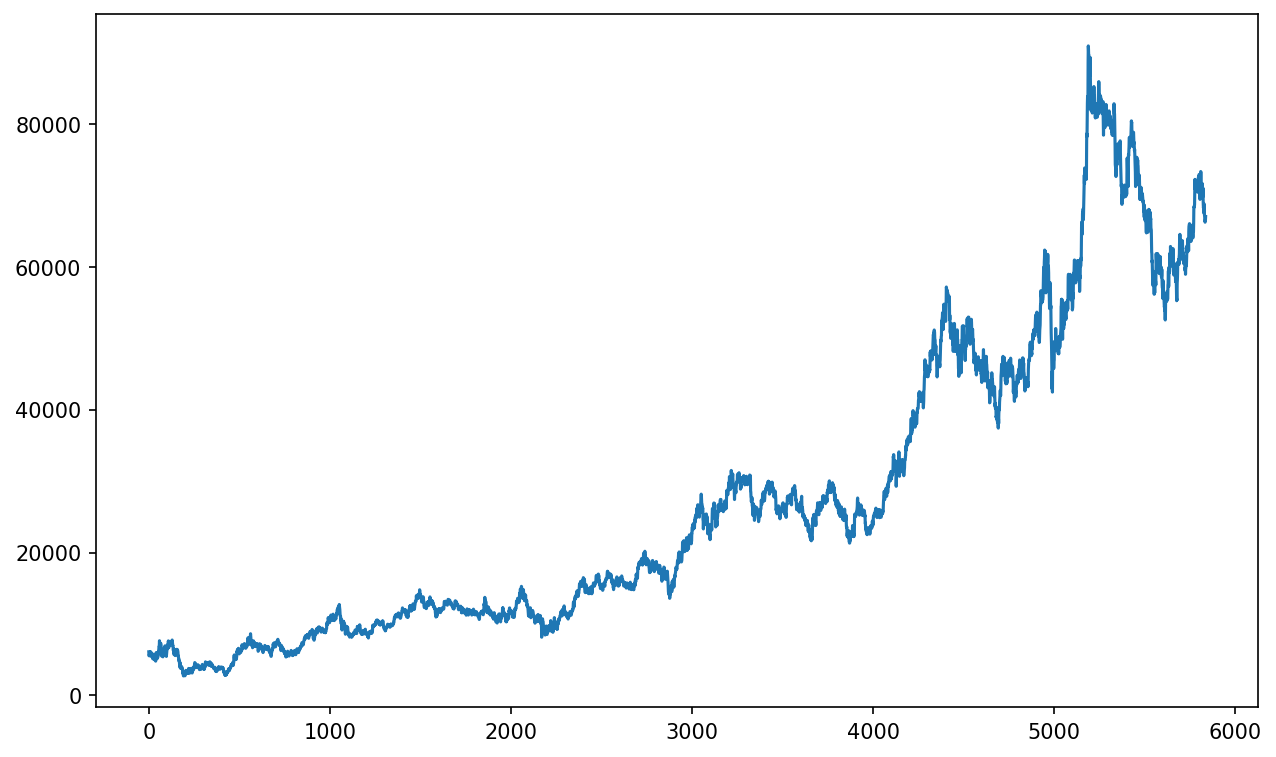

In [4]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(df["close"])
plt.show()

In [5]:
close = df["close"].to_numpy()
close

array([ 6110,  5580,  5620, ..., 66600, 66600, 67100])

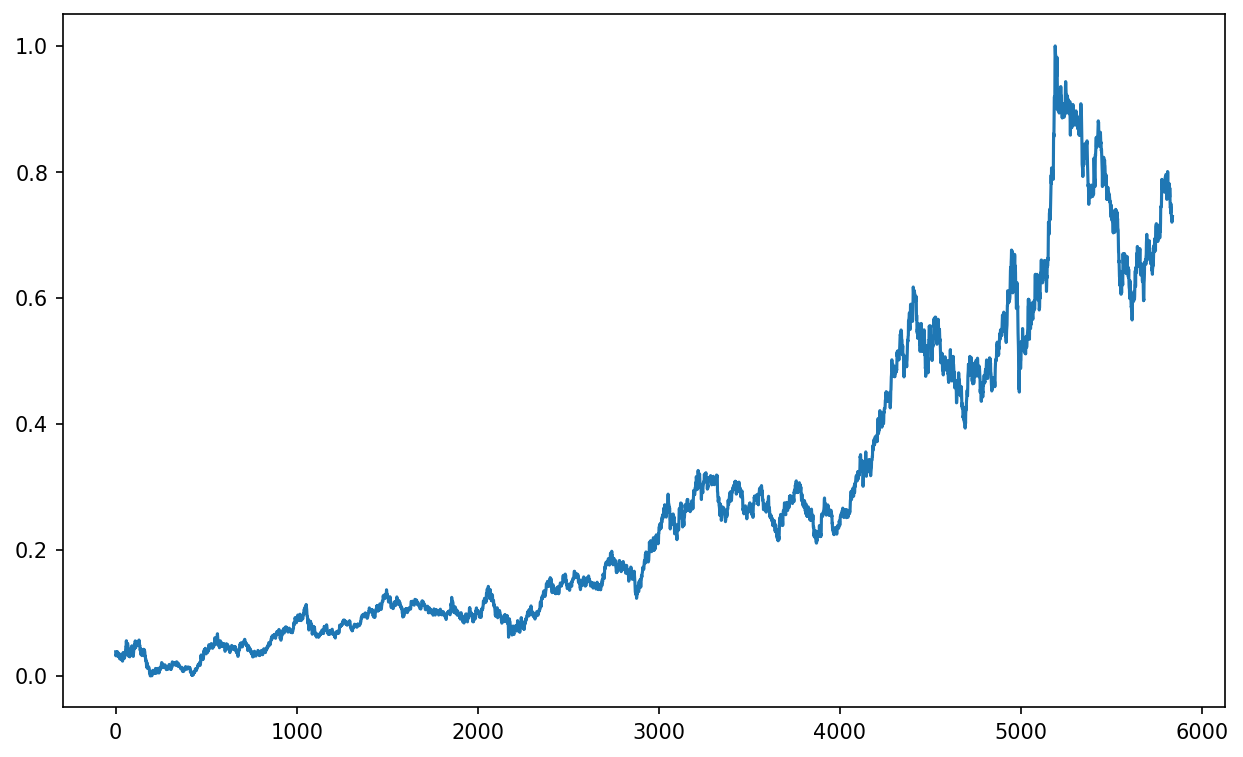

In [6]:
# Normalize
close, close_max, close_min = normalize(close)

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(close)
plt.show()

In [7]:
# bias augmentation
biases = [0.0, 0.25, 0.5, 0.75]
close_aug = np.array([close + bias for bias in biases])
close_aug.shape

(4, 5838)

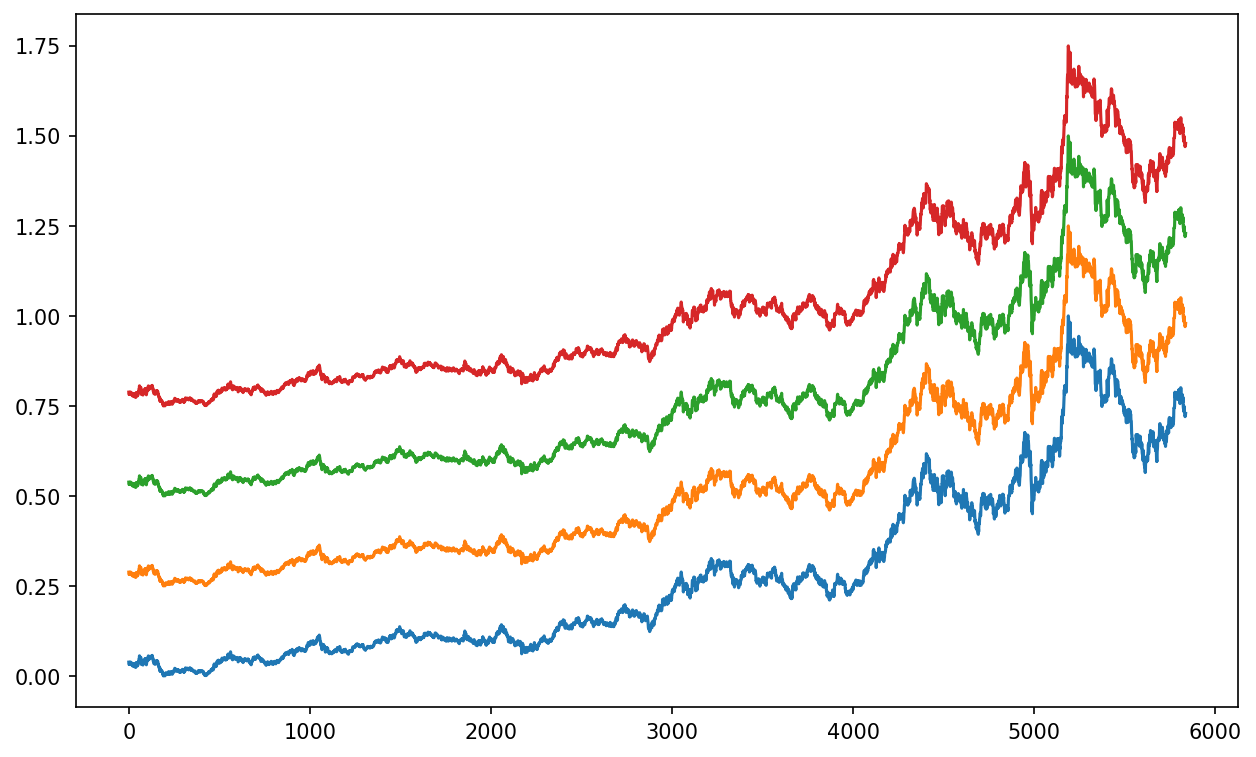

In [8]:
plt.figure(figsize=(10, 6), dpi=150)
for i in range(close_aug.shape[0]):
    plt.plot(close_aug[i])
plt.show()

In [9]:
window_size = 5
horizon_size = 5

In [10]:
#x, y = sliding_window(close, 10, 10)
x_train = []
y_train = []
x_test = []
y_test = []
for bias in biases:
    x, y = sliding_window(close + bias, window_size, horizon_size)
    x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, 0.8)
    x_train.append(x_train_)
    y_train.append(y_train_)
    x_test.append(x_test_)
    y_test.append(y_test_)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

In [11]:
x_train.shape

(18652, 5)

In [12]:
x_test.shape

(4664, 5)

In [13]:
ds_train = StockDataset(x_train, y_train)
ds_test = StockDataset(x_test, y_test)

In [14]:
dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=256, shuffle=False)

In [15]:
class MLP(LightningModule):
    def __init__(self, input_size, hidden_size, output_size, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, output_size),
        )
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.HuberLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.HuberLoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [16]:
model = MLP(window_size, 32, horizon_size)
model

MLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): GELU(approximate='tanh')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='tanh')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='tanh')
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='tanh')
    (8): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [17]:
x, y = sliding_window(close, window_size, horizon_size)

In [18]:
x.shape

(5829, 5)

In [19]:
# Baseline
y_hat = model(torch.from_numpy(x).float())
y_hat = y_hat.detach().numpy()
y_hat.shape

(5829, 5)

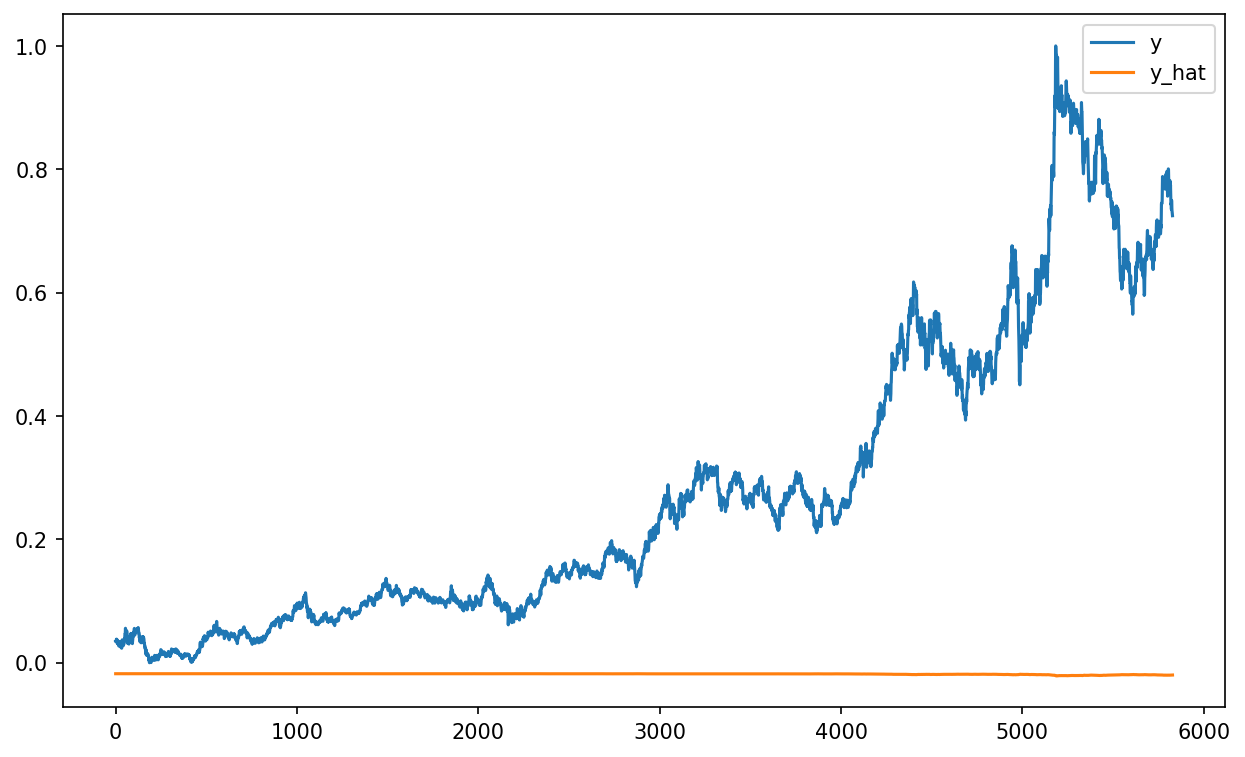

In [20]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[:, 0], label="y")
plt.plot(y_hat[:, 0], label="y_hat")
plt.legend()
plt.show()

In [21]:
# Wandb logger
wandb_logger = WandbLogger(project="stock_test")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


In [22]:
trainer = Trainer(
    devices=1,
    accelerator='auto',
    max_epochs=100,
    logger=wandb_logger,
    enable_progress_bar=False,
    callbacks=[LearningRateMonitor(logging_interval='step')],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, dl_train, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 3.5 K 
------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/MLTest/new/stock_forecasting/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xteca/Documents/Project/Machine_Learning/MLTest/new/stock_forecasting/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does n

In [25]:
# Test
y_hat = model(torch.from_numpy(x).float())
y_hat = y_hat.detach().numpy()
y_hat.shape

(5829, 5)

In [27]:
y = recover_normalize(y, close_max, close_min)
y_hat = recover_normalize(y_hat, close_max, close_min)

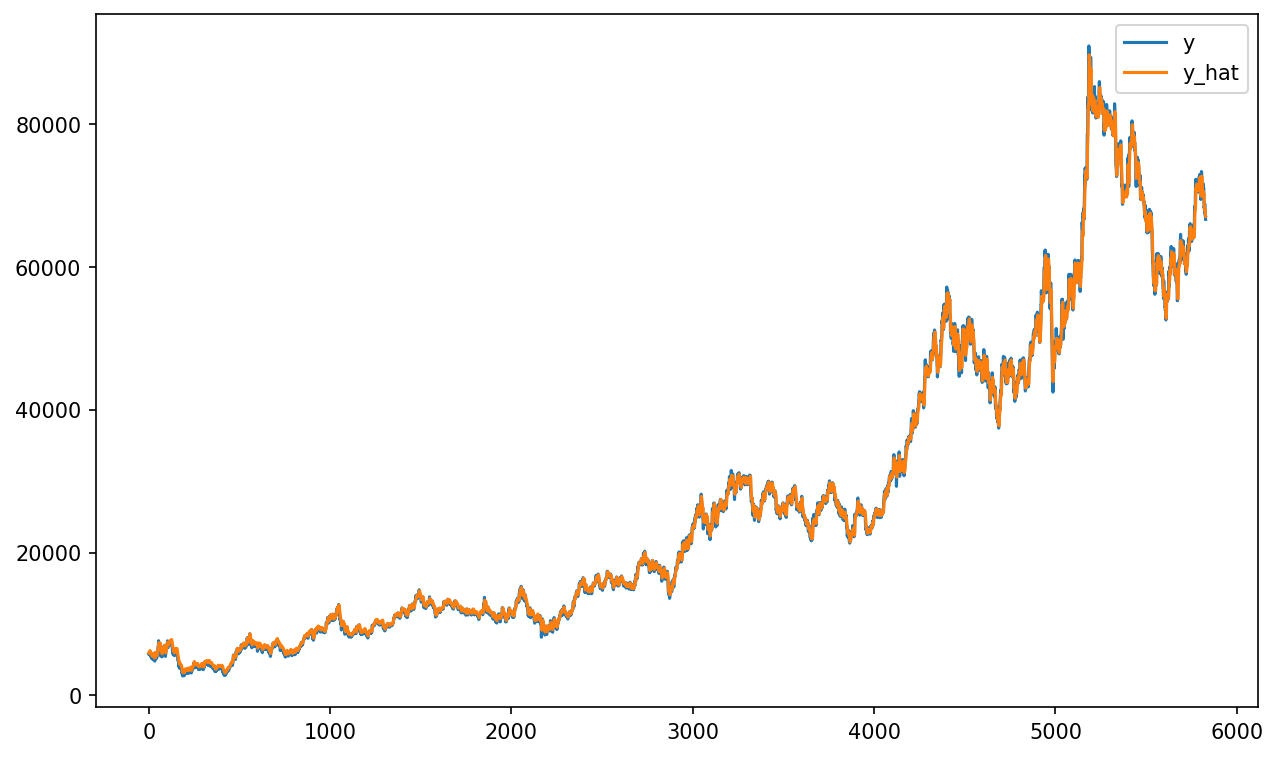

In [30]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[:, 0], label="y")
plt.plot(y_hat[:, 0], label="y_hat")
plt.legend()
plt.savefig("mlp.png", dpi=600)
plt.show()

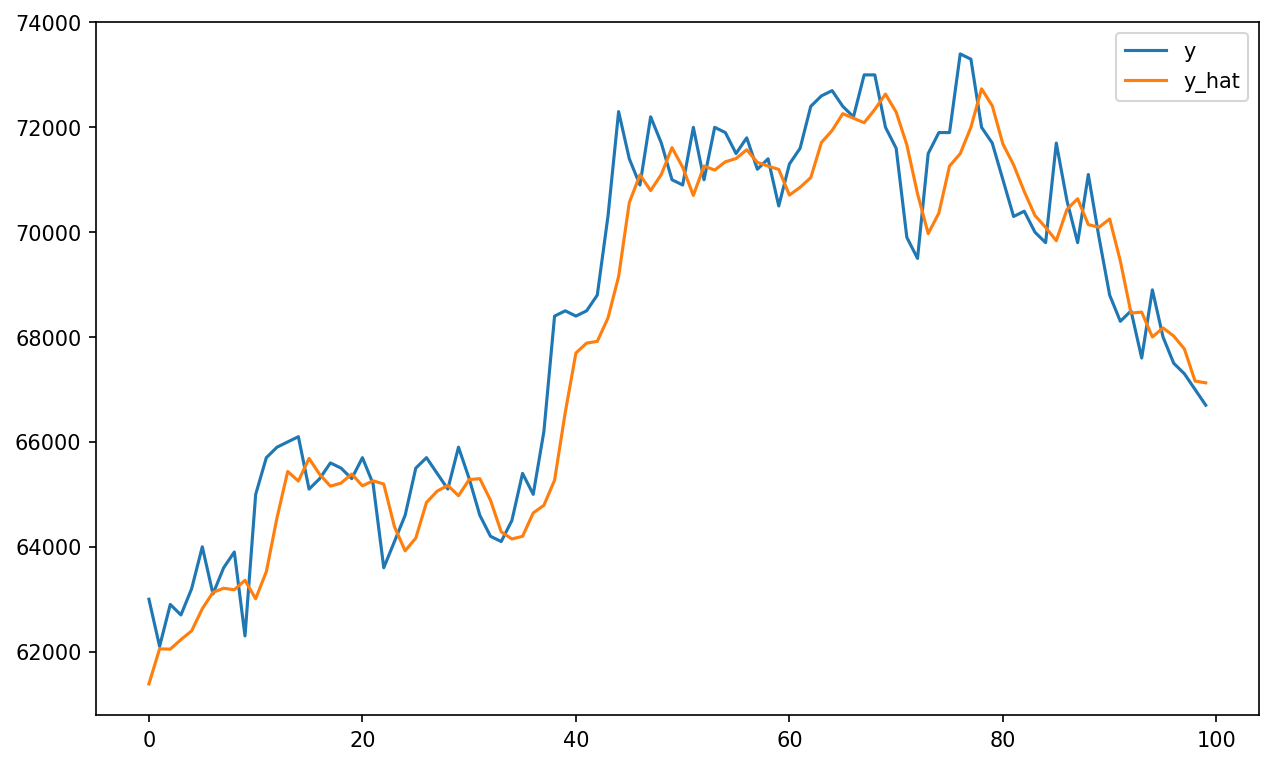

In [33]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[-100:, 0], label="y")
plt.plot(y_hat[-100:, 0], label="y_hat")
plt.legend()
plt.savefig("mlp_zoom.png", dpi=600)
plt.show()

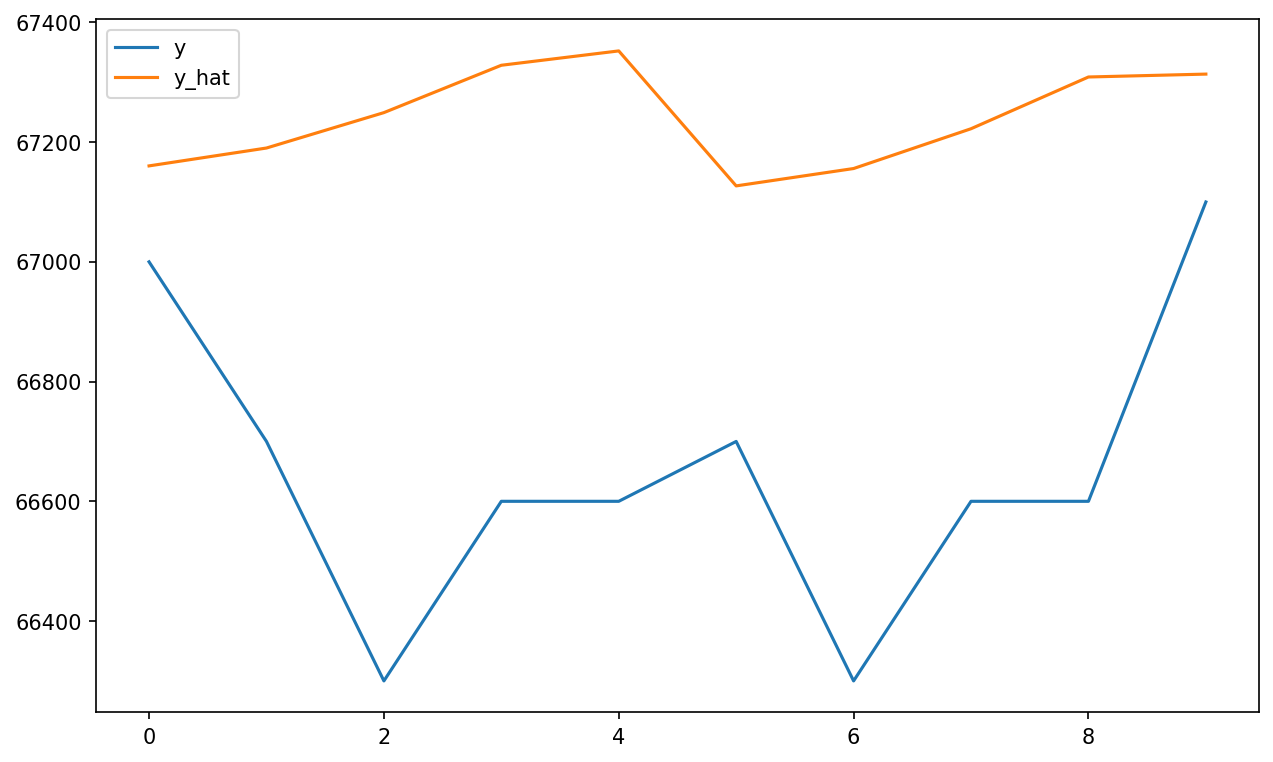

In [34]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[-2:, :].flatten(), label="y")
plt.plot(y_hat[-2:, :].flatten(), label="y_hat")
plt.legend()
plt.savefig("mlp_extra.png", dpi=600)
plt.show()